<a href="https://colab.research.google.com/github/dogakurtoglu/DSA210/blob/main/Data_Processing%26Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd
from datetime import timedelta
import csv

# Define input and output file paths
csv_input_path = "1YEAR_cycle.csv"
csv_output_ranges = "phase_date_ranges.csv"
csv_output_daily = "final_daily_cycle_table.csv"

# 1. Read the input menstrual cycle data (semicolon-delimited CSV)
df = pd.read_csv(csv_input_path, sep=";")
df["Start Date"] = pd.to_datetime(df["Start Date"], dayfirst=True)
df["End Date"] = pd.to_datetime(df["End Date"], dayfirst=True)

# 2. Generate phase blocks: Menstruation, Follicular, Ovulation, Luteal
phases = []

for _, row in df.iterrows():
    start_date = row["Start Date"]
    end_date = row["End Date"]
    cycle_length = int(row["Corrected Cycle Length"])

    # Menstruation: from start to end of period
    phases.append(["Menstruation", start_date, end_date])

    # Follicular phase: starts after menstruation and lasts 9 days before ovulation
    follicular_start = end_date + timedelta(days=1)
    ovulation_start = follicular_start + timedelta(days=9)
    follicular_end = ovulation_start - timedelta(days=1)
    phases.append(["Follicular", follicular_start, follicular_end])

    # Ovulation: defined as a 2-day window
    ovulation_end = ovulation_start + timedelta(days=1)
    phases.append(["Ovulation", ovulation_start, ovulation_end])

    # Luteal: remainder of the cycle until the day before the next period
    luteal_start = ovulation_end + timedelta(days=1)
    luteal_end = start_date + timedelta(days=cycle_length - 1)
    phases.append(["Luteal", luteal_start, luteal_end])

# 3. Export the phase blocks as a CSV file
with open(csv_output_ranges, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(["Phase", "Start Date", "End Date"])
    for row in phases:
        writer.writerow([row[0], row[1].strftime("%Y-%m-%d"), row[2].strftime("%Y-%m-%d")])

print(f" Phase range CSV saved: {csv_output_ranges}")

# 4. Expand the phase blocks to daily resolution (no date gaps)
daily_phase = []
for phase, start, end in phases:
    current = start
    while current <= end:
        daily_phase.append({"date": current, "phase": phase})
        current += timedelta(days=1)

# 5. Convert to DataFrame and export daily phase assignments
daily_phase_df = pd.DataFrame(daily_phase)
daily_phase_df = daily_phase_df.sort_values("date").reset_index(drop=True)
daily_phase_df.to_csv(csv_output_daily, index=False)
print(f" Daily phase mapping saved: {csv_output_daily}")

# 6. Preview the output files
from IPython.display import display
print("\n Sample phase block output:")
display(pd.read_csv(csv_output_ranges).head())

print("\n Sample daily phase table:")
display(pd.read_csv(csv_output_daily).head())


 Phase range CSV saved: phase_date_ranges.csv
 Daily phase mapping saved: final_daily_cycle_table.csv

 Sample phase block output:


,Phase,Start Date,End Date
0,Menstruation,2025-04-11,2025-04-16
1,Follicular,2025-04-17,2025-04-25
2,Ovulation,2025-04-26,2025-04-27
3,Luteal,2025-04-28,2025-05-07
4,Menstruation,2025-03-15,2025-03-20



 Sample daily phase table:


,date,phase
0,2024-05-06,Menstruation
1,2024-05-07,Menstruation
2,2024-05-08,Menstruation
3,2024-05-09,Menstruation
4,2024-05-10,Menstruation


In [120]:
import pandas as pd

# Load the input file containing phase date ranges
phase_df = pd.read_csv("phase_date_ranges.csv")

# Clean up column names (remove extra spaces, if any)
phase_df.columns = phase_df.columns.str.strip()

# Convert the Start and End Date columns to datetime objects
phase_df["Start Date"] = pd.to_datetime(phase_df["Start Date"])
phase_df["End Date"] = pd.to_datetime(phase_df["End Date"])

# Initialize an empty list to hold daily rows for each phase
daily_phase_rows = []

# Expand each phase range into individual daily records
for _, row in phase_df.iterrows():
    phase = row["Phase"]
    start_date = row["Start Date"]
    end_date = row["End Date"]

    # Use pd.date_range to generate one row per date within the range
    for date in pd.date_range(start=start_date, end=end_date):
        daily_phase_rows.append({
            "date": date,
            "phase": phase
        })

# Create a DataFrame from the expanded daily phase data
daily_phase_df = pd.DataFrame(daily_phase_rows)

# Sort chronologically by date and reset index
daily_phase_df = daily_phase_df.sort_values("date").reset_index(drop=True)

# Remove duplicate entries for the same day (keep only the last one, e.g. Luteal over Ovulation if overlapping)
daily_phase_df = daily_phase_df.drop_duplicates(subset=["date"], keep="last")

# Save the final daily phase assignments to CSV
daily_phase_df.to_csv("daily_phase_series.csv", index=False)

# Display a preview ( first 28 days of the dataset)
display(daily_phase_df.head(28))


,date,phase
0,2024-05-06,Menstruation
1,2024-05-07,Menstruation
2,2024-05-08,Menstruation
3,2024-05-09,Menstruation
4,2024-05-10,Menstruation
5,2024-05-11,Menstruation
6,2024-05-12,Follicular
7,2024-05-13,Follicular
8,2024-05-14,Follicular
9,2024-05-15,Follicular


In [121]:
# 1. Create daily rows for each period range (flagged with is_period = 1)
period_flags = []

# Loop through each period block to mark all days as part of a period
for _, row in df.iterrows():
    start = row["Start Date"]
    end = row["End Date"]

    # Generate daily entries between start and end (inclusive)
    for date in pd.date_range(start=start, end=end):
        period_flags.append({"date": date, "is_period": 1})

# 2. Create a complete date range covering the entire timeline in the dataset
all_dates = pd.date_range(df["Start Date"].min(), df["Start Date"].max())

# Initialize a daily DataFrame with default is_period = 0 (i.e., not a period day)
daily_df = pd.DataFrame({"date": all_dates})
daily_df["is_period"] = 0

# 3. Create a DataFrame from the flagged period days
period_df = pd.DataFrame(period_flags)

# Set is_period = 1 for dates that are marked as part of a period
daily_df.loc[daily_df["date"].isin(period_df["date"]), "is_period"] = 1


In [122]:
# Ensure that both DataFrames have their date columns in datetime format
daily_df["date"] = pd.to_datetime(daily_df["date"])
daily_phase_df["date"] = pd.to_datetime(daily_phase_df["date"])

# Perform an outer merge on 'date' to align period flags with hormonal phases
# This allows all days to be included, even if phase information is missing for some
final_df = pd.merge(daily_df, daily_phase_df, on="date", how="left")

# Replace missing phase values with "Unknown" (optional but improves clarity)
final_df["phase"].fillna("Unknown", inplace=True)

# Save the final merged dataset to a CSV file
final_df.to_csv("final_daily_cycle_table.csv", index=False)

# Display a preview of the first 28 rows (for validation)
display(final_df.head(28))


,date,is_period,phase
0,2024-05-06,1,Menstruation
1,2024-05-07,1,Menstruation
2,2024-05-08,1,Menstruation
3,2024-05-09,1,Menstruation
4,2024-05-10,1,Menstruation
5,2024-05-11,1,Menstruation
6,2024-05-12,0,Follicular
7,2024-05-13,0,Follicular
8,2024-05-14,0,Follicular
9,2024-05-15,0,Follicular


In [123]:
from itertools import groupby
from operator import itemgetter

# Step 1: Sort the daily data by date to ensure proper grouping
daily_phase_df = daily_phase_df.sort_values("date")

# Step 2: Convert the DataFrame to a list of namedtuples (each row becomes a record)
records = list(daily_phase_df.itertuples(index=False))

# Step 3: Group consecutive rows with the same phase using itertools.groupby
grouped_ranges = []

for phase, group in groupby(records, key=lambda x: x.phase):
    group = list(group)  # group is a generator, convert to list for indexing
    start = group[0].date  # first date in the group
    end = group[-1].date   # last date in the group

    # Append the summarized range to the results list
    grouped_ranges.append({
        "Phase": phase,
        "Start Date": start.strftime("%Y-%m-%d"),
        "End Date": end.strftime("%Y-%m-%d")
    })

# Step 4: Create a DataFrame from the grouped results
range_df = pd.DataFrame(grouped_ranges)

# Step 5: Display a sample of the result (first 10 rows)
display(range_df.head(10))


,Phase,Start Date,End Date
0,Menstruation,2024-05-06,2024-05-11
1,Follicular,2024-05-12,2024-05-20
2,Ovulation,2024-05-21,2024-05-22
3,Luteal,2024-05-23,2024-06-08
4,Menstruation,2024-06-12,2024-06-18
5,Follicular,2024-06-19,2024-06-27
6,Ovulation,2024-06-28,2024-06-29
7,Luteal,2024-06-30,2024-07-02
8,Menstruation,2024-07-03,2024-07-03
9,Luteal,2024-07-04,2024-07-05


In [124]:
# save as CSV file
range_df.to_csv("phase_blocks_from_daily.csv", index=False)
print("Faz blokları başarıyla kaydedildi: phase_blocks_from_daily.csv")


Faz blokları başarıyla kaydedildi: phase_blocks_from_daily.csv


In [125]:
import pandas as pd

# ---read Excel file ---
xls_path = "harcama_verisi.xls"
df = pd.read_excel(xls_path, sheet_name=0, skiprows=15)

# ---  clean the data ---
df = df.dropna(how="all", axis=1)
df.columns = df.columns.str.strip()
df = df.dropna(subset=["Tarih/Saat", "Açıklama", "İşlem Tutarı*"])
df["Açıklama"] = df["Açıklama"].astype(str).str.upper()

# --- convert the amounts to float---
df["İşlem Tutarı*"] = (
    df["İşlem Tutarı*"]
    .astype(str)
    .str.replace(",", ".")
    .str.replace(" TRY", "")
    .str.replace("TL", "")
    .str.extract(r"([-+]?[0-9]*\.?[0-9]+)")
    .astype(float)
)
def tutar_araligi(tutar):
    tutar_abs = abs(tutar)  # since the expenditures are - signed take teh absoulte value of it
    if tutar_abs <= 100:
        return "[0-100]"
    elif tutar_abs <= 500:
        return "[100-500]"
    elif tutar_abs <= 1000:
        return "[500-1000]"
    elif tutar_abs <= 2000:
        return "[1000-2000]"
    elif tutar_abs <= 5000:
        return "[2000-5000]"
    else:
        return "[5000+]"


df["Tutar Aralığı"] = df["İşlem Tutarı*"].apply(tutar_araligi)


In [126]:
# ---  specialized categories ) ---
kategori_sozluk = {
    "market & shopping": ["MIGROS", "CARREFOUR", "A101", "ŞOK", "BIM", "DOST MARKET", "SOK", "MARKET","MEDIAMARKT", "ITX", "IYZICO", "APPLE", "SAMSUNG", "VODAFONE"],
    "dessert": ["KAHVE DUNYASI", "PASTANE", "CUPCAKE", "TATLI", "BAKLAVA", "BITES", "ASUMAN", "BREKKIE", "CEVIZAGACI", "PACOTTA", "CHOCOLATE", "SWEET","YOMUMU"],
    "cosmetics": ["WATSONS", "ROSSMANN", "YVES ROCHER", "LOREAL", "KİKO", "BATH","ERA KUAFOR", "KUAFÖR"],
    "food": ["RESTAURANT", "YEMEKSEPETI", "PIZZA", "BURGER", "DONER", "NUSRET", "MIDPOINT", "SUSHICO", "HOOK", "GURME", "HMR", "KOKOREC", "MUTFAK", "SAPA", "GIDA", "KOPUKLU KAHVE", "SBX", "INTIBA", "PILAV", "KUCUK EV", "SIMIT SARAYI", "EATALY","AKADEMI"],
    "clothing": ["TRENDYOL", "ZARA", "BERSHKA", "MANGO", "LCW", "CALZEDONIA", "OXXO", "SHEIN", "SHEISMONO", "CHAKRA", "SHAYA", "PENTI","SUPERSTEP","SOLE", "AKSESUAR", "YATAS", "SKECHERS"],
    "coffee": ["STARBUCKS", "CAFE", "DUT", "TEA SHOP", "BREWLAB", "NERO", "COFFY", "POCO","BISTRO"],
    "transportation": ["GUR-SEL", "METRO TURIZM", "PEGASUS", "UBER", "BELBIM", "KART", "ISTANBULKART", "IETT", "MARMARAY", "OTOBÜS"],
    "education": ["UDEMY", "UNICOURSE", "UNIVERSITE", "SABANCI", "INSTITUT", "HOMER","HOMER", "KITAPEVI", "D&R", "YAYINEVI"],
    "travel": ["PEGASUS", "UÇAK", "BILETINIAL", "HOTEL", "AIRBNB", "BOOKING", "TURIZM"],
    "subscriptions": ["SPOTIFY", "NETFLIX", "BLUTV"],
    "money_transfer": ["FAST", "AKTARILAN", "TRANSFER", "EFT", "ÜCRET H"],
    "fuel": ["PETROL", "SHELL", "AYPARA", "ATLI PETROL", "OPET"],
    "health": ["ECZANE", "ECZANESI", "ORGANIK ECZANE", "SAGLIK"],
    "other": []
}

# --- categorie it  ---
def kategorize(aciklama):
    aciklama = str(aciklama).upper()  # in case of any lower letter
    for kategori, anahtarlar in kategori_sozluk.items():
        if any(anahtar in aciklama for anahtar in anahtarlar):
            return kategori
    return "other"

# Uygula
df["Kategori"] = df["Açıklama"].apply(kategorize)




In [127]:
# --- Step 7: Convert the date column and select relevant fields ---
# Parse the "Tarih/Saat" column into datetime format (day-first)
df["Tarih/Saat"] = pd.to_datetime(df["Tarih/Saat"], dayfirst=True, errors="coerce")

# Select only relevant columns and rename for consistency
df_kategorili = df[["Tarih/Saat", "Açıklama", "Kategori", "İşlem Tutarı*", "Tutar Aralığı"]].rename(
    columns={"Tarih/Saat": "date"}
)

# --- Step 8: Save the cleaned and categorized dataset to CSV ---
df_kategorili.to_csv("harcama_kategorili_aciklama_ve_tutar.csv", index=False)
print(" Categorized spending data successfully saved as: harcama_kategorili_aciklama_ve_tutar.csv")

# --- Step 9: Preview the first 10 rows of the output ---
df_kategorili.head(10)


 Categorized spending data successfully saved as: harcama_kategorili_aciklama_ve_tutar.csv


,date,Açıklama,Kategori,İşlem Tutarı*,Tutar Aralığı
0,2025-04-23 20:38:45,FLYPEGASUS PGS364236639 ISTANBUL 6233,transportation,-2300.00,[2000-5000]
1,2025-04-23 18:54:59,7036 ISTANBUL SABANCI UNIISTANBUL 6233,education,-168.69,[100-500]
2,2025-04-22 19:02:35,EATALY-ZORLU YAPI YATIRIMISTANBUL 6233,food,-125.00,[100-500]
3,2025-04-22 18:54:51,EATALY-ZORLU YAPI YATIRIMISTANBUL 6233,food,-594.00,[500-1000]
4,2025-04-22 16:21:12,GUR-SEL TURIZM ISTANBUL 6233,transportation,-150.00,[100-500]
5,2025-04-21 20:26:56,PAYTR/MATIK ISTANBUL 6233,other,-32.00,[0-100]
6,2025-04-21 20:06:37,MONEYPAY/MIGROSONE ISTANBUL 6233,market & shopping,-1293.21,[1000-2000]
7,2025-04-21 11:52:52,KUCUK EV SABANCI UNIVER ISTANBUL 6233,food,-166.00,[100-500]
8,2025-04-20 20:54:10,INTIBA ISTANBUL 6233,food,-550.00,[500-1000]
9,2025-04-19 21:12:34,BILETINIAL BILET BASIM VEISTANBUL 6233,travel,-471.00,[100-500]


In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from tabulate import tabulate
import matplotlib.patches as mpatches
import numpy as np
from scipy.stats import mannwhitneyu
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib.colors import LogNorm
from scipy.stats import pearsonr
#in case of any forgotten imports i used them all here

In [129]:
import warnings
warnings.filterwarnings('ignore')

In [130]:
dessert_data = merged[merged["Kategori"] == "dessert"]
print(dessert_data["phase"].value_counts())
luteal_desserts = dessert_data[dessert_data["phase"] == "Luteal"]
print(len(luteal_desserts))


phase
Menstruation    4
Luteal          2
Follicular      2
Ovulation       1
Name: count, dtype: int64
2


In [131]:
#  Dessert kategorisini al
dessert_data = merged[merged["Kategori"].str.lower() == "dessert"].copy()
dessert_data["abs_tutar"] = pd.to_numeric(dessert_data["İşlem Tutarı*"], errors="coerce").abs()

#  calculate IQR
Q1 = dessert_data["abs_tutar"].quantile(0.25)
Q3 = dessert_data["abs_tutar"].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

#  filter non outlier data
filtered_dessert = dessert_data[dessert_data["abs_tutar"] <= upper_bound]

#  seperate according to phases
luteal = filtered_dessert[filtered_dessert["phase"] == "Luteal"]["abs_tutar"].dropna()
other = filtered_dessert[filtered_dessert["phase"] != "Luteal"]["abs_tutar"].dropna()

#  real mean differences
obs_diff = luteal.mean() - other.mean()

#  combine data for Permutation
all_values = np.concatenate([luteal, other])
labels = ['Luteal'] * len(luteal) + ['Other'] * len(other)

#  Permutation test
diffs = []
for _ in range(10000):
    np.random.shuffle(labels)
    g1 = all_values[np.array(labels) == 'Luteal']
    g2 = all_values[np.array(labels) == 'Other']
    diffs.append(np.mean(g1) - np.mean(g2))

diffs = np.array(diffs)
p_perm = np.mean(diffs >= obs_diff)

# 9. print results
print("🎯 Permutation Test (Outlier-Filtered) – Dessert Spending (Luteal vs Other)")
print(f"Observed Mean Difference: {obs_diff:.2f}")
print(f"P-value (one-sided): {p_perm:.4f}")
print(f"Reject Null Hypothesis: {p_perm < 0.05}")


🎯 Permutation Test (Outlier-Filtered) – Dessert Spending (Luteal vs Other)
Observed Mean Difference: 4.64
P-value (one-sided): 0.4534
Reject Null Hypothesis: False


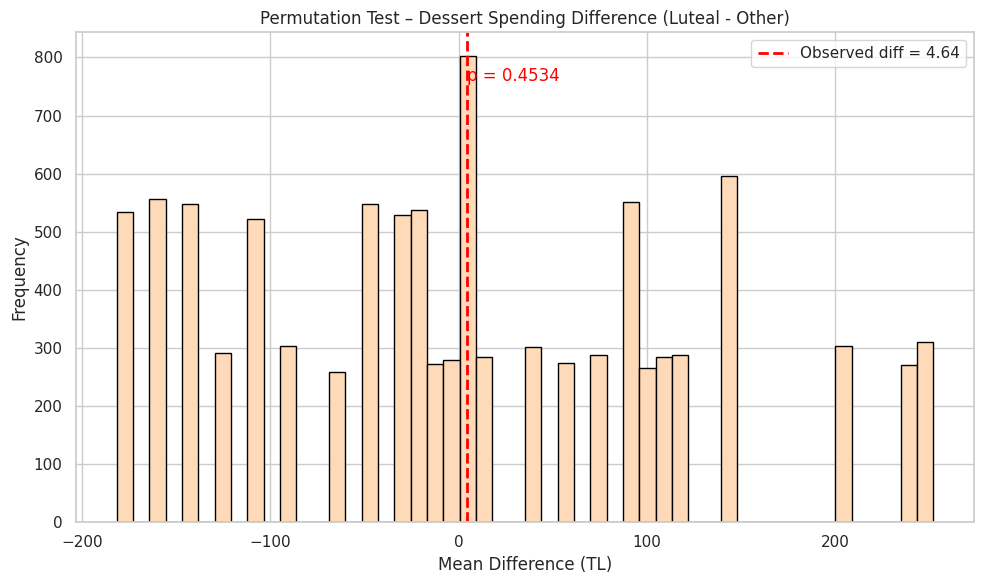

In [132]:
# 9.Visualize with Histogram
plt.figure(figsize=(10, 6))
plt.hist(diffs, bins=50, color='peachpuff', edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='--', linewidth=2, label=f'Observed diff = {obs_diff:.2f}')
plt.title("Permutation Test – Dessert Spending Difference (Luteal - Other)")
plt.xlabel("Mean Difference (TL)")
plt.ylabel("Frequency")
plt.legend()
plt.text(obs_diff, plt.ylim()[1]*0.9, f'p = {p_perm:.4f}', color='red')
plt.tight_layout()
plt.show()


In [133]:
# 1. Filter dessert category data
dessert_data = merged[merged["Kategori"].str.lower() == "dessert"].copy()

# 2. Convert spending values to numeric and take absolute value
dessert_data["abs_tutar"] = pd.to_numeric(dessert_data["İşlem Tutarı*"], errors="coerce").abs()

# 3. Group data by phase
luteal_desserts = dessert_data[dessert_data["phase"] == "Luteal"]["abs_tutar"].dropna()
other_desserts = dessert_data[dessert_data["phase"] != "Luteal"]["abs_tutar"].dropna()

# 4. Mann–Whitney U Test (one-sided: Luteal > Other)
u_stat, p_value = mannwhitneyu(luteal_desserts, other_desserts, alternative='greater')

# 5. Print results
print("🔬 Mann–Whitney U Test (One-Sided, Full Dataset)")
print("H₀: Luteal phase dessert spending is less than or equal to other phases.")
print("H₁: Luteal phase dessert spending is greater than other phases.")
print(f"U-Statistic: {u_stat}")
print(f"P-Value: {p_value:.4f}")
print(f"Reject H₀: {p_value < 0.05}")


🔬 Mann–Whitney U Test (One-Sided, Full Dataset)
H₀: Luteal phase dessert spending is less than or equal to other phases.
H₁: Luteal phase dessert spending is greater than other phases.
U-Statistic: 8.0
P-Value: 0.4444
Reject H₀: False


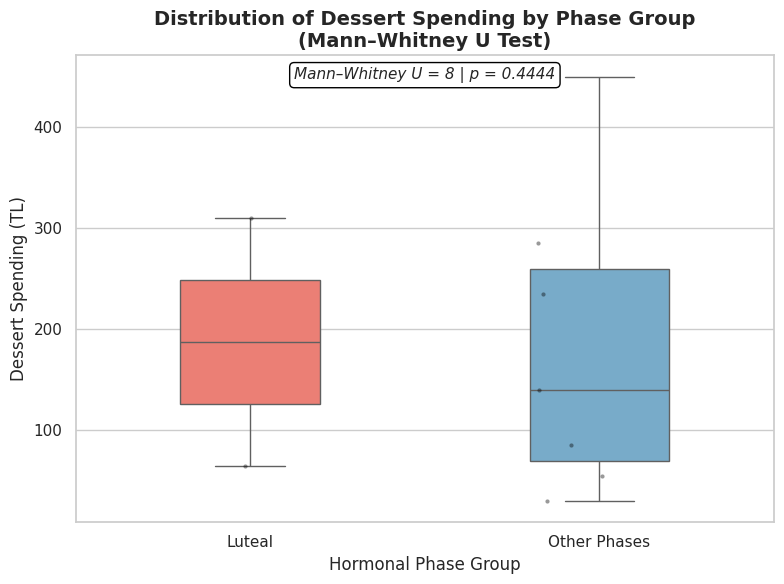

In [134]:
# 1. prepare data for visualization
df_vis = pd.DataFrame({
    "Spending (TL)": pd.concat([luteal_desserts, other_desserts]),
    "Phase": ["Luteal"] * len(luteal_desserts) + ["Other Phases"] * len(other_desserts)
})

# 2. Boxplot + stripplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_vis, x="Phase", y="Spending (TL)", width=0.4, fliersize=0, palette=["#FF6F61", "#6BAED6"])
sns.stripplot(data=df_vis, x="Phase", y="Spending (TL)", color='black', alpha=0.4, jitter=0.2, size=3)

# 3. visualization of axes
plt.title("Distribution of Dessert Spending by Phase Group\n(Mann–Whitney U Test)", fontsize=14, weight="bold")
plt.xlabel("Hormonal Phase Group", fontsize=12)
plt.ylabel("Dessert Spending (TL)", fontsize=12)

# 4. Annotation: U-statistic ve p-value
plt.text(
    x=0.5,
    y=plt.ylim()[1]*0.95,
    s=f"Mann–Whitney U = {u_stat:.0f} | p = {p_value:.4f}",
    ha='center',
    fontsize=11,
    style='italic',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

plt.tight_layout()
plt.show()


In [135]:
# filter Cosmetics data
cosmetics_data = merged[merged["Kategori"] == "cosmetics"].copy()

# seperateLuteal vs other phases
cosmetics_data["phase_group"] = cosmetics_data["phase"].apply(lambda x: "Luteal" if x == "Luteal" else "Other Phases")

# get non NaNtransactions
luteal_cosmetics = cosmetics_data[cosmetics_data["phase"] == "Luteal"]["İşlem Tutarı*"].dropna().abs()
other_cosmetics = cosmetics_data[cosmetics_data["phase"] != "Luteal"]["İşlem Tutarı*"].dropna().abs()


In [136]:
# real mean difference
obs_diff = np.mean(luteal_cosmetics) - np.mean(other_cosmetics)

# combine data
all_values = np.concatenate([luteal_cosmetics, other_cosmetics])
labels = ['Luteal'] * len(luteal_cosmetics) + ['Other'] * len(other_cosmetics)

# Permutasyon
n_perm = 10000
diffs = []

for _ in range(n_perm):
    np.random.shuffle(labels)
    group1 = all_values[np.array(labels) == 'Luteal']
    group2 = all_values[np.array(labels) == 'Other']
    diffs.append(np.mean(group1) - np.mean(group2))

diffs = np.array(diffs)

# 🔍 One-tailed p-value (greater): Luteal > Other
p_value_one_sided = np.mean(diffs >= obs_diff)


# 📢 Output
print("🔬 Permutation Test – One-tailed (Luteal > Other)")
print(f"Observed Mean Difference: {obs_diff:.2f}")
print(f"P-Value: {p_value_one_sided:.4f}")
print(f"Reject H₀: {p_value_one_sided < 0.05}")



🔬 Permutation Test – One-tailed (Luteal > Other)
Observed Mean Difference: 99.44
P-Value: 0.3683
Reject H₀: False


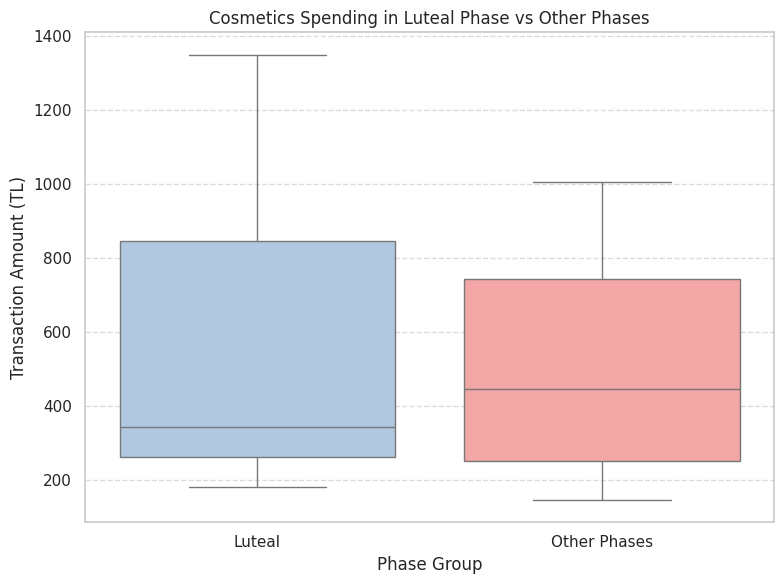

In [137]:
cosmetics_data["abs_tutar"] = cosmetics_data["İşlem Tutarı*"].abs()

plt.figure(figsize=(8, 6))
sns.boxplot(data=cosmetics_data, x="phase_group", y="abs_tutar", palette=["#A7C7E7", "#FF9999"])
plt.title("Cosmetics Spending in Luteal Phase vs Other Phases")
plt.xlabel("Phase Group")
plt.ylabel("Transaction Amount (TL)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [138]:
# 1. filter Clothing category
clothing_data = merged[merged["Kategori"] == "clothing"].copy()
clothing_data["abs_tutar"] = clothing_data["İşlem Tutarı*"].abs()

# 2. Ovulation vs Other
clothing_data["phase_group"] = clothing_data["phase"].apply(lambda x: "Ovulation" if x == "Ovulation" else "Other")

# 3. Grup data
group_ovu = clothing_data[clothing_data["phase_group"] == "Ovulation"]["abs_tutar"].dropna()
group_other = clothing_data[clothing_data["phase_group"] == "Other"]["abs_tutar"].dropna()

# 4. Mann-Whitney U test
u_stat_ov, p_val_ov = mannwhitneyu(group_ovu, group_other, alternative="greater")

# 5. results
print("Hypothesis: Clothing Spending During Ovulation vs Other Phases")
print("Null Hypothesis (H0): Clothing spending is not higher during the Ovulation phase.")
print("Alternative Hypothesis (H1): Clothing spending is higher during the Ovulation phase.")
print(f"U-Statistic: {u_stat_ov}")
print(f"P-Value: {p_val_ov}")
print(f"Reject Null Hypothesis: {p_val_ov < 0.05}")


Hypothesis: Clothing Spending During Ovulation vs Other Phases
Null Hypothesis (H0): Clothing spending is not higher during the Ovulation phase.
Alternative Hypothesis (H1): Clothing spending is higher during the Ovulation phase.
U-Statistic: 12.0
P-Value: 0.5555555555555556
Reject Null Hypothesis: False


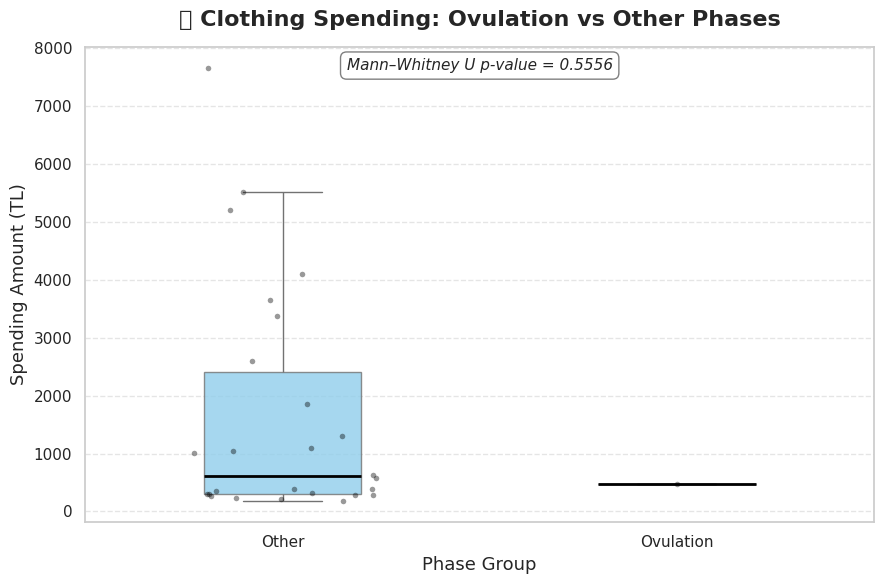

In [139]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(9, 6))

# Boxplot
sns.boxplot(
    data=clothing_data,
    x="phase_group",
    y="abs_tutar",
    palette=["#81D4FA", "#F8BBD0"],
    width=0.4,
    boxprops=dict(alpha=0.8),
    medianprops=dict(color='black', linewidth=2),
    fliersize=0
)

# Stripplot (noktalar)
sns.stripplot(
    data=clothing_data,
    x="phase_group",
    y="abs_tutar",
    color="black",
    alpha=0.4,
    jitter=0.25,
    size=4
)

# Başlık ve eksenler
plt.title("👗 Clothing Spending: Ovulation vs Other Phases", fontsize=16, weight='bold', pad=15)
plt.xlabel("Phase Group", fontsize=13)
plt.ylabel("Spending Amount (TL)", fontsize=13)

# P-value anotasyonu
plt.text(
    0.5,
    plt.ylim()[1] * 0.95,
    f"Mann–Whitney U p-value = {p_val_ov:.4f}",
    ha="center",
    fontsize=11,
    style='italic',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='gray')
)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [140]:
# --- 1. upload files---
spend_df = pd.read_csv("harcama_kategorili_aciklama_ve_tutar.csv", parse_dates=["date"])
phase_df = pd.read_csv("final_daily_cycle_table.csv", parse_dates=["date"])

# --- 2. normalize dates ---
spend_df["date"] = pd.to_datetime(spend_df["date"]).dt.date
phase_df["date"] = pd.to_datetime(phase_df["date"]).dt.date

# --- 3. add phase informations ---
merged = spend_df.merge(phase_df, on="date", how="left")
merged = merged[merged["phase"].isin(["Menstruation", "Follicular", "Ovulation", "Luteal"])]

# --- 4. define weeks ---
merged["week"] = pd.to_datetime(merged["date"]).dt.to_period("W").apply(lambda x: x.start_time)

# --- 5.define dominant phase   ---
phase_counts = merged.groupby(["week", "phase"]).size().reset_index(name="days")
dominant_phase = (
    phase_counts.sort_values(["week", "days"], ascending=[True, False])
    .drop_duplicates("week")[["week", "phase"]]
    .rename(columns={"phase": "dominant_phase"})
)

# --- 6. weekly total expenditures---
weekly_total = merged.groupby("week")["İşlem Tutarı*"].sum().abs().reset_index()
dominant_phase["week"] = pd.to_datetime(dominant_phase["week"]).dt.date
weekly_total["week"] = pd.to_datetime(weekly_total["week"]).dt.date
weekly_total = weekly_total.merge(dominant_phase, on="week", how="left")

# --- 7. tag the phase gruops ---
weekly_total["phase_group"] = weekly_total["dominant_phase"].apply(
    lambda x: "Luteal" if x == "Luteal" else "Other"
)

# --- 8. Welch's t-test ---
luteal = weekly_total[weekly_total["phase_group"] == "Luteal"]["İşlem Tutarı*"]
other = weekly_total[weekly_total["phase_group"] == "Other"]["İşlem Tutarı*"]
t_stat, p_val = ttest_ind(luteal, other, equal_var=False, alternative="greater")

# --- 9. print results ---
print(" Hypothesis: Weekly Spending is Higher in the Luteal Phase")
print("H0: Mean weekly spending is not higher in the luteal phase.")
print("H1: Mean weekly spending is higher in the luteal phase.")
print(f"T-Statistic: {t_stat:.3f}")
print(f"P-Value: {p_val:.4f}")
print(f"Reject Null Hypothesis: {'Yes' if p_val < 0.05 else 'No'}")




 Hypothesis: Weekly Spending is Higher in the Luteal Phase
H0: Mean weekly spending is not higher in the luteal phase.
H1: Mean weekly spending is higher in the luteal phase.
T-Statistic: -0.668
P-Value: 0.7453
Reject Null Hypothesis: No


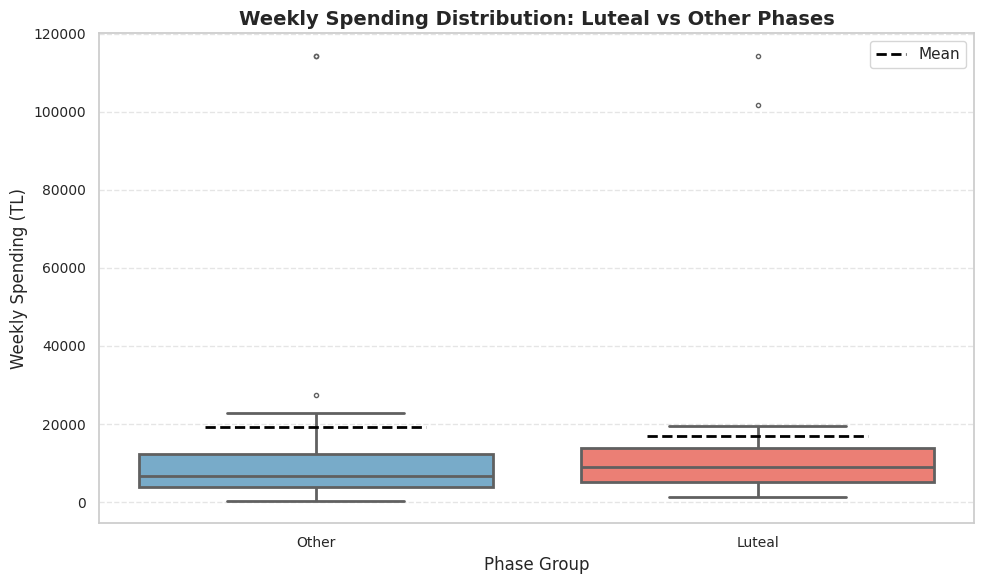

In [141]:
# crop for limit
max_y = weekly_total["İşlem Tutarı*"].quantile(0.95)  # %95'e kadar
filtered_data = weekly_total.copy()
filtered_data["İşlem Tutarı*"] = filtered_data["İşlem Tutarı*"].clip(upper=max_y)

# color palet
custom_palette = {"Luteal": "#FF6F61", "Other": "#6BAED6"}

# Plot
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(
    data=filtered_data,
    x="phase_group",
    y="İşlem Tutarı*",
    palette=custom_palette,
    linewidth=2,
    fliersize=3
)

# mean lines
means = filtered_data.groupby("phase_group")["İşlem Tutarı*"].mean()
for i, (label, mean_val) in enumerate(means.items()):
    plt.hlines(
        y=mean_val,
        xmin=i - 0.25,
        xmax=i + 0.25,
        colors='black',
        linestyles='--',
        linewidth=2,
        label="Mean" if i == 0 else None
    )

# headers
plt.title("Weekly Spending Distribution: Luteal vs Other Phases", fontsize=14, weight='bold')
plt.xlabel("Phase Group", fontsize=12)
plt.ylabel("Weekly Spending (TL)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


In [142]:
# 1. Filter all transactions labeled as 'coffee'
coffee_df = merged[merged["Kategori"] == "coffee"].copy()
coffee_df["date"] = pd.to_datetime(coffee_df["date"])

# 2. Create a flag (1) for each date where coffee was purchased
coffee_flags = pd.DataFrame({
    "date": coffee_df["date"].unique(),
    "coffee_spent": 1
})

# 3. Merge with the daily menstrual phase data that includes the 'is_period' binary flag
period_daily = final_df[["date", "is_period"]].copy()
daily = pd.merge(period_daily, coffee_flags, on="date", how="left").fillna(0)

# 4. Create a 2x2 contingency table:
# Rows → period vs non-period days
# Columns → coffee purchase vs no coffee purchase
contingency = pd.crosstab(daily["is_period"], daily["coffee_spent"])

# 5. Perform a one-sided Fisher’s Exact Test (better for small sample sizes)
# H₁: Coffee purchases are more likely during period days
oddsratio, p_value = fisher_exact(contingency, alternative='greater')

# 6. Display the results
print("☕ Fisher Exact Test – Coffee Purchases on Period vs Non-Period Days")
print("H₀: Coffee purchase rate is the same or lower on period days.")
print("H₁: Coffee purchase rate is higher on period days.")
print(f"Contingency Table:\n{contingency}")
print(f"P-value: {p_value:.4f}")
print(f"Reject H₀: {p_value < 0.05}")


☕ Fisher Exact Test – Coffee Purchases on Period vs Non-Period Days
H₀: Coffee purchase rate is the same or lower on period days.
H₁: Coffee purchase rate is higher on period days.
Contingency Table:
coffee_spent  0.0  1.0
is_period             
0             244   30
1              53   14
P-value: 0.0283
Reject H₀: True


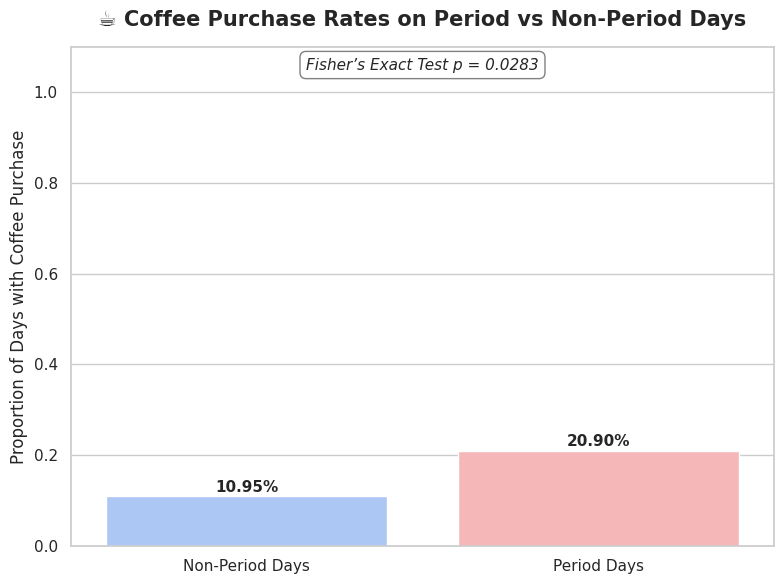

In [143]:
# 1. calculate Proportion
grouped = daily.groupby("is_period")["coffee_spent"].agg(["sum", "count"])
grouped["proportion"] = grouped["sum"] / grouped["count"]
grouped = grouped.reset_index()
grouped["Period Status"] = grouped["is_period"].map({0: "Non-Period Days", 1: "Period Days"})

# 2. Plot settings
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))
bar = sns.barplot(
    data=grouped,
    x="Period Status",
    y="proportion",
    palette=["#A0C4FF", "#FFADAD"]
)

# 3. write the proportions on Bar
for i, p in enumerate(bar.patches):
    height = p.get_height()
    bar.text(
        x=p.get_x() + p.get_width() / 2,
        y=height + 0.01,
        s=f"{height:.2%}",
        ha='center',
        fontsize=11,
        fontweight='bold'
    )

# 4. headers
plt.title("☕ Coffee Purchase Rates on Period vs Non-Period Days", fontsize=15, weight='bold', pad=15)
plt.ylabel("Proportion of Days with Coffee Purchase", fontsize=12)
plt.xlabel("")

# 5. P-değeri anotation
plt.text(
    0.5,
    1.05,
    f"Fisher’s Exact Test p = {p_value:.4f}",
    ha="center",
    fontsize=11,
    style='italic',
    bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.4')
)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()
